# Import Libraries

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
import glob
from sklearn import preprocessing

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input

from tensorflow.keras import layers
from tensorflow.random import normal



# 1. Read data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1 Load Label .csv file into dataframe

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Studies/mabd/trainset/data.csv')
# Have a first look at csv file 
df = pd.read_csv('/content/drive/MyDrive/data.csv')

# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv')
df.head(10)

,id,values
0,0,oō
1,1,oö
2,2,eê
3,3,oó
4,4,ii
5,5,eë
6,6,uū
7,7,ii
8,8,eè
9,9,oò


In [ ]:
# Correct the label of the first image, as it is wronlgy labeled.
df.loc[0, "values"] = "oo"
df.head(3)

,id,values
0,0,oo
1,1,oö
2,2,eê


 ## 1.2. Data Pre Analysis


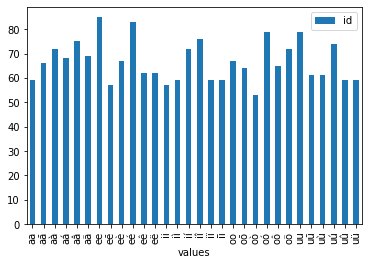

In [ ]:
# Histogram of classes 
# (make sample weighting???) 
df.groupby('values').count().plot(kind = 'bar')

In [ ]:
# check for font and for color distribution of letters 
counts = df.groupby('values').count().to_dict()
counts = counts['id']
df['sample_weight']= df['values'].map(counts)
df['sample_weight'] = (100 - df['sample_weight'])/100
sample_weight = df['sample_weight'].values

In [ ]:
sample_weight

array([0.33, 0.28, 0.38, ..., 0.32, 0.28, 0.35])

# 2. Label Preprocessing

## 2.1 One hot encode the labels 

In [ ]:
le = preprocessing.LabelEncoder()
df["label"] = le.fit_transform(df['values'])
labels = df["label"].to_list()
n_classes = len(df["values"].unique())

indices = labels
depth = n_classes
labels = tf.one_hot(indices, depth, on_value=1.0, off_value=0.0)

## 2.2 Create tensorflow dataset from images and ohe labels

In [ ]:
# im_dir = '/content/drive/MyDrive/Studies/mabd/trainset/images_train/'
# im_dir = '/content/drive/MyDrive/Colab Notebooks/images_train/'
im_dir = '/content/drive/MyDrive/images_train/'


ext = ['png'] # Multiple images' formats accepted

files = []
[files.extend(glob.glob(im_dir + '*.' + e)) for e in ext]
files.sort()

filenames = tf.constant(files)
len_data = len(df['id'])
# print(len_data)

dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))#, sample_weight))

# 3. Preprocess images 
## 3.1 Crop and cast to float 

In [ ]:
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_png(image_string, channels=3)
    image_cropped = tf.image.crop_to_bounding_box(
        image_decoded, 35, 56, 80, 72
    )
    # image, offset_height, offset_width, target_height, target_width
    image = tf.cast(image_cropped, tf.float32) / 255
    
    return image, label #, sample_weight

dataset = dataset.map(_parse_function)
dataset = dataset.batch(len_data)

iterator = iter(dataset)
images, labels = iterator.get_next()

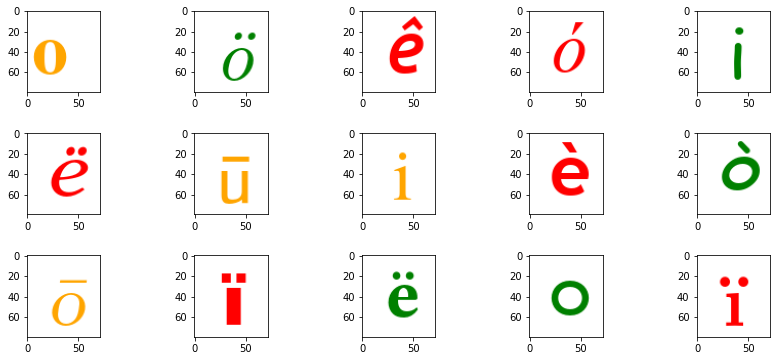

In [ ]:
# print some examples of first preprocessing result
def print_examples(x, df):
    fig, axs = plt.subplots(3, 5, figsize=(15, 6))
    fig.subplots_adjust(hspace = .5, wspace=.001)

    axs = axs.ravel()

    for i in range(15):
        axs[i].imshow(x[i])
        # axs[i].set_title(f"{i}: {df.loc[i, 'values']}")
    
print_examples(images, df)

## 3.2 Convert to grayscale

tf.Tensor([56 56  1], shape=(3,), dtype=int32)


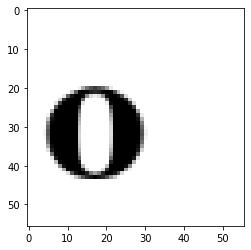

In [ ]:
gray_images = tf.image.rgb_to_grayscale(images)
# gray_images = gray_images *(-1) # trial to see if images work inverted better 
gray_images = tf.image.resize(gray_images, [56,56])
plt.imshow(gray_images[0].numpy().squeeze(axis=2), cmap='gray')

# plt.imshow(gray_images[0].numpy().squeeze(axis=2), cmap='gray')

shape = tf.shape(gray_images[0])
print(tf.shape(gray_images[0]))

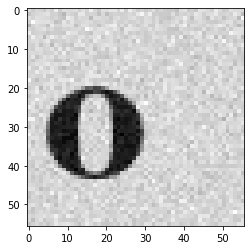

In [ ]:
# Adding Gaussian noise to one image 
noise = tf.random.normal(shape=shape, mean=0.0, stddev=.02, dtype=tf.float32)
noise_img = tf.add(gray_images[0], noise)#*(-1)

plt.imshow(noise_img.numpy().squeeze(axis=2), cmap='gray')

## 3.3 Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.00),
    # layers.RandomFlip(mode="horizontal_and_vertical"),
    # layers.RandomFlip(mode="horizontal"), 
    # layers.RandomZoom(
        # height_factor=(-0.3, 0),
        # width_factor=(-0.3, 0),
        # seed=42,
    # ), 
    # layers.GaussianNoise(stddev=0.01, seed=None)
])

# aug_images = tf.concat([gray_images, data_augmentation(gray_images, training=True)], 0)
aug_images = tf.concat([gray_images, gray_images], 0)
labels_long = tf.concat([labels, labels], 0)
sample_weight_long = tf.concat([sample_weight, sample_weight], 0)
data_len = len(labels_long)
print(data_len)

# aug_ds = tf.data.Dataset.from_tensor_slices((aug_images, labels_long))

# aug_images_1 = tf.concat([aug_images, data_augmentation(aug_images, training = True)], 0)
aug_images_1 = tf.concat([aug_images, aug_images], 0)

labels_long_long = tf.concat([labels_long, labels_long], 0)
sample_weight_long_long = tf.concat([sample_weight_long, sample_weight_long], 0)

data_len = len(labels_long_long)
print(data_len)

aug_ds = tf.data.Dataset.from_tensor_slices((aug_images_1, labels_long_long))#, sample_weight_long_long))
aug_ds = aug_ds#.shuffle(data_len, reshuffle_each_iteration=True)


4000
8000


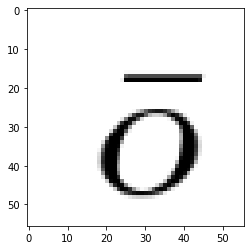

In [ ]:
plt.imshow(aug_images_1[4010].numpy().squeeze(axis=2), cmap='gray')


## 3.4. Train- Validation Split

In [ ]:
batch_size = 50

train_split = 0.8
val_split = 0.2

train_size = int(train_split * data_len)
val_size = int(val_split * data_len)

train_ds = aug_ds.take(train_size).batch(batch_size).shuffle(train_size, reshuffle_each_iteration=True)
val_ds = aug_ds.skip(train_size).take(val_size).batch(batch_size)#.shuffle(val_size, reshuffle_each_iteration=True)

# train_ds = aug_ds.take(train_size).shuffle(train_size, reshuffle_each_iteration=True)
# val_ds = aug_ds.skip(train_size).take(val_size)

print(train_size)
print(val_size)
print(aug_ds)
print(train_ds)

# print_examples(aug_images.numpy().squeeze(axis=-1), df)

6400
1600
<TensorSliceDataset element_spec=(TensorSpec(shape=(56, 56, 1), dtype=tf.float32, name=None), TensorSpec(shape=(30,), dtype=tf.float32, name=None))>
<ShuffleDataset element_spec=(TensorSpec(shape=(None, 56, 56, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30), dtype=tf.float32, name=None))>


# 4. Create a model

In [ ]:
from tensorflow.keras import regularizers

def create_model_small():
  model = tf.keras.Sequential()
  model.add(Input(shape=(56, 56, 1)))
  model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'))
  model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(rate=0.0)) #0.25
  
  # model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'))
  # model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'))
  # model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  # model.add(tf.keras.layers.BatchNormalization())
  # model.add(tf.keras.layers.Dropout(rate=0.25))
  
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(l2=0.01)))
  model.add(tf.keras.layers.Dropout(rate=0.0)) #0.5
  model.add(tf.keras.layers.Dense(128, activation="relu"))
  model.add(tf.keras.layers.Dropout(rate=0.0)) #0.5
  model.add(tf.keras.layers.Dense(30, activation="softmax"))

  return model

# inpiration for the big model: 784 - [32C3-32C3-32C5S2] - [64C3-64C3-64C5S2] - 128 - 10
# with 40% dropout, batch normalization, and data augmentation added
# https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist/notebook

In [ ]:
model_6 = create_model_small()
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/checkpoints_6'
model_6.load_weights(checkpoint_filepath)
model_6.summary(line_length=None, positions=None, print_fn=None)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 56, 56, 32)        320       
                                                                 
 conv2d_41 (Conv2D)          (None, 56, 56, 32)        9248      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 dropout_45 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 flatten_17 (Flatten)        (None, 25088)             0         
                                                                 
 dense_51 (Dense)            (None, 512)               12845568  
                                                     

# 5. Train model

In [ ]:
# before creating model 7, set dropout to 0 
model_7 = create_model_small()
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/checkpoints_6'
model_7.load_weights(checkpoint_filepath)
model_7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 2

checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/checkpoints_7'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

print(batch_size)

trained_model_7 = model_7.fit(train_ds, epochs=epochs, batch_size = batch_size, validation_data=val_ds, callbacks=[model_checkpoint_callback])


50
Epoch 1/2
128/128 [==============================] - 7s 39ms/step - loss: 0.3106 - accuracy: 0.9994 - val_loss: 0.2513 - val_accuracy: 1.0000
Epoch 2/2
128/128 [==============================] - 4s 30ms/step - loss: 0.2120 - accuracy: 0.9998 - val_loss: 0.1771 - val_accuracy: 0.9994


# 6. Plot Training history 


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


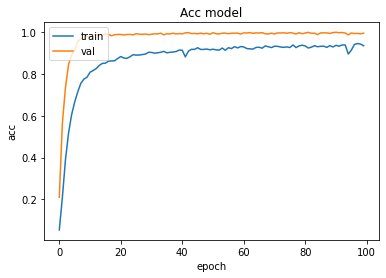

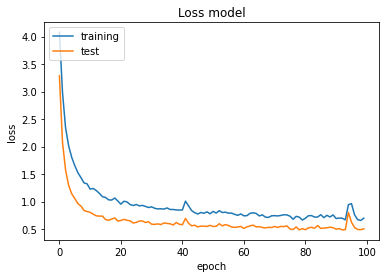

In [ ]:
print(trained_model_5.history.keys())
# trained model 5 is the 100 epoch trained model 

model_history = trained_model_5

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Acc model')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'test'], loc='upper left')
plt.show()

In [ ]:
# 784 - [32C3-32C3-32C5S2] - [64C3-64C3-64C5S2] - 128 - 10
# with 40% dropout, batch normalization, and data augmentation added
# https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist/notebook


In [ ]:
model_final = create_model_small()
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/checkpoints_6'
model_final.load_weights(checkpoint_filepath)
model_final.summary(line_length=None, positions=None, print_fn=None)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                        

In [ ]:
predictions = model_final.predict(gray_images)
predictions = np.array(predictions)
preds = np.argmax(predictions, axis = 1)
values = le.inverse_transform(preds)
preds[0:5]

array([18, 23, 10, 21, 12])

In [ ]:
values[0:5]

array(['oo', 'oö', 'eê', 'oó', 'ii'], dtype=object)

In [ ]:
y_true = np.array(df['label'])
df.head(5)

,id,values,sample_weight,label
0,0,oo,0.33,18
1,1,oö,0.28,23
2,2,eê,0.38,10
3,3,oó,0.21,21
4,4,ii,0.43,12


In [ ]:
from sklearn.metrics import log_loss  
# Where y_pred is a matrix of probabilities with shape = (n_samples, n_classes) and y_true is an array of class labels
score = log_loss(y_true, predictions, eps=1e-15)
1- score

0.9958614974935405

# 8. Test Set Prediction

In [ ]:
# load images 
test_dir = '/content/drive/MyDrive/images_test/'

ext = ['png'] # Multiple images' formats accepted

files = []
[files.extend(glob.glob(test_dir + '*.' + e)) for e in ext]
files.sort()

filenames_test = tf.constant(files)
len_testdata = len(filenames_test)
labels_test = tf.ones(shape = (len_testdata))

dataset = tf.data.Dataset.from_tensor_slices((filenames_test, labels_test))

dataset = dataset.map(_parse_function)
dataset = dataset.batch(len_testdata)

iterator = iter(dataset)
test_images, test_labels = iterator.get_next()


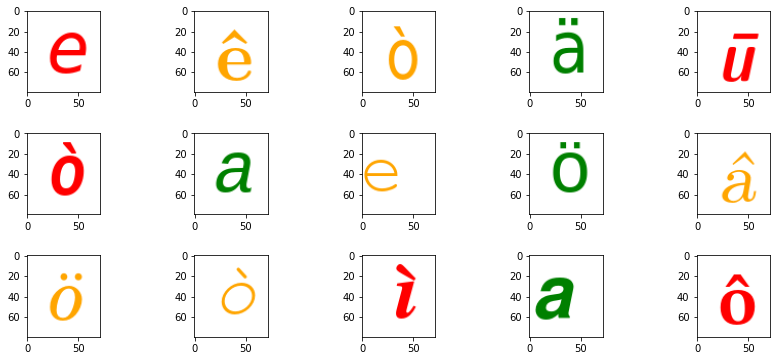

In [ ]:
print_examples(test_images, df)

tf.Tensor([56 56  1], shape=(3,), dtype=int32)


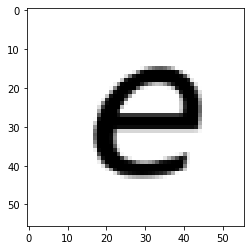

In [ ]:
# preprocess images 
gray_test_images = tf.image.rgb_to_grayscale(test_images)
# gray_images = gray_images *(-1) # trial to see if images work inverted better 
gray_test_images = tf.image.resize(gray_test_images, [56,56])
plt.imshow(gray_test_images[0].numpy().squeeze(axis=2), cmap='gray')

print(tf.shape(gray_test_images[0]))

In [ ]:
test_predictions = model_final.predict(gray_test_images)
test_predictions = np.array(test_predictions)
preds_test = np.argmax(test_predictions, axis = 1)
test_values_1 = le.inverse_transform(preds_test)
# test_values_1[0:2000] = test_values[0:2000]


In [ ]:
preds_test[0:5]
test_values_1 = values

In [ ]:
def show_image_pred(x):
  plt.imshow(gray_test_images[x].numpy().squeeze(axis=2), cmap='gray')
  print(test_values_1[x])

uū


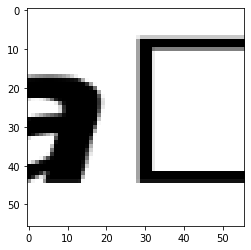

In [ ]:
x = 2100
show_image_pred(x)

In [ ]:
test_values_1[x] = 'aa'

In [ ]:
le.classes_

array(['aa', 'aā', 'aà', 'aá', 'aâ', 'aä', 'ee', 'eē', 'eè', 'eé', 'eê',
       'eë', 'ii', 'iì', 'ií', 'iî', 'iï', 'iı̄', 'oo', 'oō', 'oò', 'oó',
       'oô', 'oö', 'uu', 'uū', 'uù', 'uú', 'uû', 'uü'], dtype=object)

In [ ]:
a = np.asarray(test_values_1)
np.savetxt("/content/drive/MyDrive/values.csv", a, fmt='%s')

In [ ]:
test_values_1

array(['ee', 'eê', 'oò', ..., 'aâ', 'uu', 'uù'], dtype=object)

In [ ]:
id = np.asarray(range(0,len(test_values_1)))

In [ ]:
id

array([   0,    1,    2, ..., 4997, 4998, 4999])

In [ ]:
id.shape

(5000,)

In [ ]:
final_df = pd.DataFrame({'id':id, 'values':test_values_1})

In [ ]:
final_df

,id,values
0,0,ee
1,1,eê
2,2,oò
3,3,aä
4,4,uū
...,...,...
4995,4995,aā
4996,4996,iî
4997,4997,aâ
4998,4998,uu


In [ ]:
# final_df.to_csv("/content/drive/MyDrive/test_predictions.csv", sep=',', index = False)

In [ ]:
val = pd.read_csv("/content/drive/MyDrive/values.csv", header = None)

In [ ]:
values = np.asarray(val[0])

In [ ]:
values.shape

(5000,)